# Data Augmentation for Covid-19 Classification

## An Introduction to the Study

Allen Chang
29 March 2024

**Abstract**
In early 2019, the novel coronavirus began rapidly spreading around the globe. At the 
time, there was little known about the virus and no known treatment and vaccines. At present, 
much more research has been conducted, and there is much more abundant data for disease 
analysis. Here, I create deep learning models to classify whether a patient has coronavirus based 
on chest x-ray scans. I also experiment with various data augmentation methods to identify 
which one results in best performance. 

**Introduction**
According to the WHO, as of July 2021, there have been approximately 190,833,853 
confirmed Covid-19 cases and 4,100,087 confirmed Covid-19 related deaths [1]. Thus, this is a 
severe worldwide pandemic. With Covid-19 being incredibly widespread, having a quick, 
efficient, and accurate method to determine whether a patient is infected is crucial. Typically,
deep learning models benefit from increased training data. Thus, I will experiment with various 
augmentation methods to increase training data and examine whether they present better model 
performance. 

**Methodology**
In this study, I will utilize a CNN model architecture to identify individuals infected with 
COVID-19. One model will be trained on duplicated normal training data, one model will be 
trained on Gaussian blurred data concatenated with normal training data, and one model will be 
trained on scaled data. I will compare the models using various metrics including F1-score, 
accuracy, AUROC, precision, and recall. 
The data can be found here: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/data

**Expected Results**
I expect the models trained on augmented data to see a statistically significant 
improvement from the model trained on normal training data due to the model being able to 
adapt to natural variation in scans. Nevertheless, I am eager to see which augmentation method
performs better. 
A relatively small sample size may be one limitation. Furthermore, more architectures 
can be tested. More trials can also be done to better assess if there is truly a significant difference 
between augmentation methods. 

**References** [1]	S. U. Rehman, S. U. Rehman, and H. H. Yoo, “COVID-19 challenges and its therapeutics,” Biomed. Pharmacother., vol. 142, p. 112015, Oct. 2021, doi: 10.1016/j.biopha.2021.112015.



**Extra References** The authors of the dataset have asked the following two sources to be cited:
-M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, M. T. Islam, “Can AI help in screening Viral and COVID-19 pneumonia?” IEEE Access, Vol. 8, 2020, pp. 132665 - 132676.
-Rahman, T., Khandakar, A., Qiblawey, Y., Tahir, A., Kiranyaz, S., Kashem, S.B.A., Islam, M.T., Maadeed, S.A., Zughaier, S.M., Khan, M.S. and Chowdhury, M.E., 2020. Exploring the Effect of Image Enhancement Techniques on COVID-19 Detection using Chest X-ray Images. arXiv preprint arXiv:2012.02238.

## Computational Analysis

In [218]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import * 
import cv2
import os
from PIL import Image
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint
from skimage.metrics import mean_squared_error

### Data Loading and Processing

In [4]:
trainC = '/Users/allenchang/Downloads/CovidDataset/Train/Covid'
trainN = '/Users/allenchang/Downloads/CovidDataset/Train/Normal'

valC = '/Users/allenchang/Downloads/CovidDataset/Val/Covid'
valN = '/Users/allenchang/Downloads/CovidDataset/Val/Normal'

testC = '/Users/allenchang/Downloads/CovidDataset/Test/Covid'
testN = '/Users/allenchang/Downloads/CovidDataset/Test/Normal'

In [187]:
def load_images(dir_path): # Returns images in a format that can be learned
    
    def get_all_files(directory_path): # Retrieves all files in the directory
        all_files = []
        for root, dirs, files in os.walk(directory_path):
            for file in files:
                full_path = os.path.join(root, file)
                all_files.append(full_path)
        return all_files

    def read_image(file_path): # Reads image converting it to array and resizing so all are same size
        img = cv2.imread(file_path)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = cv2.resize(img,(128,128)) # Images were resized to 128 x 128
        return img

    directory_path = dir_path
    file_paths = get_all_files(directory_path)

    image_array = []
    for file_path in file_paths:
        image_array.append(read_image(file_path))
        
    image_array = np.array(image_array)
    
    print(image_array.shape)
    return image_array

def Train_test_split(tC = trainC, tN = trainN, vC = valC, vN = valN, tsC = testC, tsN = testN): # Returns arrays of train and test, combining infected and healthy
    Xtrain_C = load_images(tC)
    Xtrain_N = load_images(tN)

    X_train = np.concatenate((Xtrain_C, Xtrain_N), axis=0)
    y_train = np.concatenate((np.ones(len(Xtrain_C)), np.zeros(len(Xtrain_N))), axis=0)
    

    Xval_C = load_images(vC)
    Xval_N = load_images(vN)

    X_val = np.concatenate((Xval_C, Xval_N), axis=0)
    y_val = np.concatenate((np.ones(len(Xval_C)), np.zeros(len(Xval_N))), axis=0)
    
    Xtest_C = load_images(tsC)
    Xtest_N = load_images(tsN)

    X_test = np.concatenate((Xtest_C, Xtest_N), axis=0)
    y_test = np.concatenate((np.ones(len(Xtest_C)), np.zeros(len(Xtest_N))), axis=0)
    
    
    return X_train, y_train, X_val, y_val, X_test, y_test
    

### Preliminary Analysis 

**Sample Description** As seen below, our training set comprises of 500 Covid positive samples and 1500 Healthy samples. The validation set comprises of 500 Covid positive samples and 1000 Healthy samples. 

In [188]:
X_train, y_train, X_val, y_val, X_test, y_test = Train_test_split()

(500, 128, 128, 3)
(1500, 128, 128, 3)
(500, 128, 128, 3)
(1000, 128, 128, 3)
(500, 128, 128, 3)
(500, 128, 128, 3)


In [225]:
def print_image(arr, slicenum, title, cmp='gray', vmax=None):
    slice_0 = arr[slicenum, :, :, 0]
    slice_1 = arr[slicenum, :, :, 1]
    slice_2 = arr[slicenum, :, :, 2]

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    im0 = axs[0].imshow(slice_0, cmap=cmp, vmax=vmax)
    axs[0].set_title(f"Slice [{slicenum}, :, :, 0]")
    axs[0].axis("off")

    im1 = axs[1].imshow(slice_1, cmap=cmp, vmax=vmax)
    axs[1].set_title(f"Slice [{slicenum}, :, :, 1]")
    axs[1].axis("off")

    im2 = axs[2].imshow(slice_2, cmap=cmp, vmax=vmax)
    axs[2].set_title(f"Slice [{slicenum}, :, :, 2]")
    axs[2].axis("off")

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im0, cax=cbar_ax)

    fig.suptitle(title, fontsize=14, fontweight="bold")
    
    plt.savefig(f'/Users/allenchang/Downloads/CovidDataset/{title}.png')

    plt.show()


### Data Augmentation

In [228]:
COVID = 0
HEALTHY = 600

In [248]:
def blur_data(X_train): # Function performs Gaussian blur using sigma value of 1.25
    blurred_images = []
    for image in X_train:
        blurred_image = np.empty_like(image)
        for depth_slice in range(image.shape[2]):
            blurred_slice = cv2.GaussianBlur(image[:, :, depth_slice], (5, 5), 1.05)

            blurred_image[:, :, depth_slice] = blurred_slice

        blurred_images.append(blurred_image)


    blurred_images = np.array(blurred_images)
    augmented_X_train = np.concatenate((X_train, blurred_images), axis=0)
    
    print_image(blurred_images, COVID, "Slice of Blurred Covid Lung")
    print_image(blurred_images, HEALTHY, "Slice of Blurred Healthy Lung")
    

    return augmented_X_train

In [230]:
def scale_data(X_train): # Functions scales the data making it 5% bigger
    scaled_images = []
    for image in X_train:
        scaled_image = np.empty_like(image)
        for depth_slice in range(image.shape[2]):
            center = (image.shape[1] // 2, image.shape[0] // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, 0, 1.02)
            scaled_slice = cv2.warpAffine(image[:, :, depth_slice], rotation_matrix, (image.shape[1], image.shape[0]))
            scaled_image[:, :, depth_slice] = scaled_slice
        scaled_images.append(scaled_image)
        
    scaled_images = np.array(scaled_images)
    
    print_image(scaled_images, COVID, "Slice of Scaled Covid Lung")
    print_image(scaled_images, HEALTHY, "Slice of Scaled Healthy Lung")
    
    
    augmented_X_train = np.concatenate((X_train, scaled_images), axis=0)
    return augmented_X_train


**Augmented Images** The images below show the same healthy and covid positive lungs. They can be compared with the blurred and scaled version. A standard deviation of 1.05 was used for the gaussian blur. For the scale augmentation method, the images were zoomed in by 2%. Augmented images were concatenated with unaltered images and shuffled. Our control model has the original 2000 samples (500 Covid + 1500 Healthy) while our augmented models have 4000 samples (500 Covid + 1500 Healthy + 500 Augmented Covid + 1500 Augmented Healthy). 

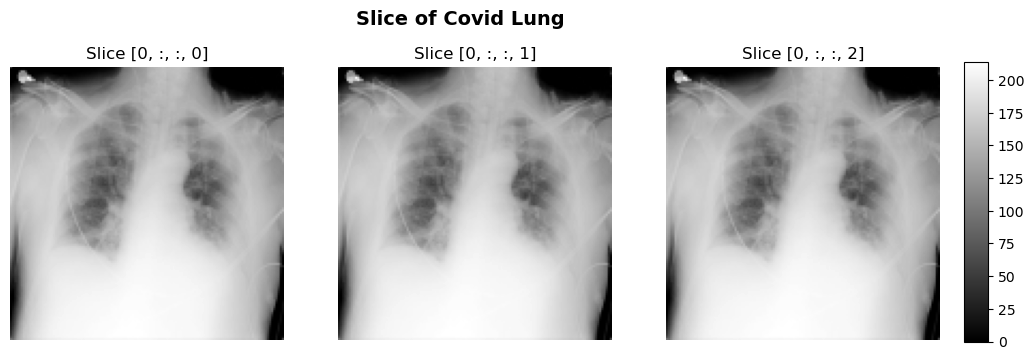

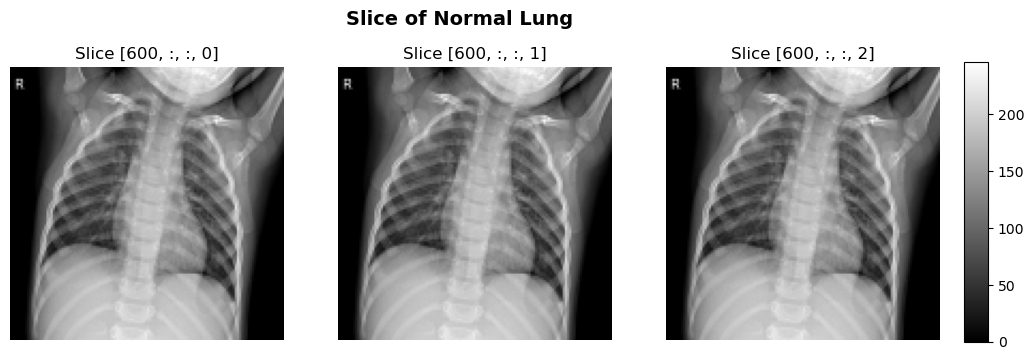

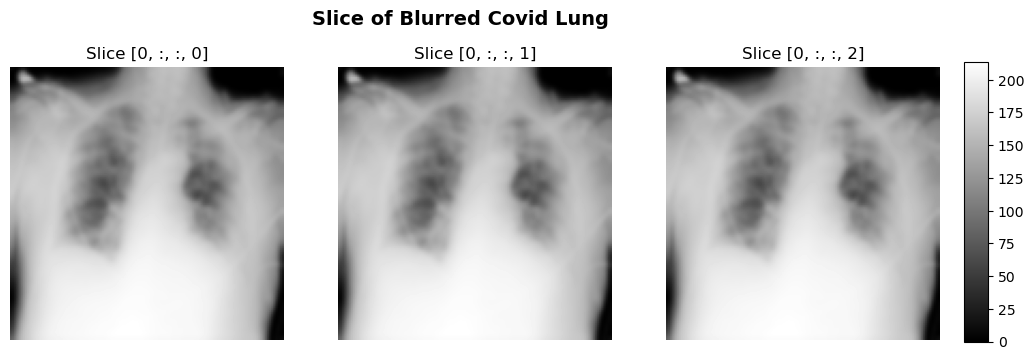

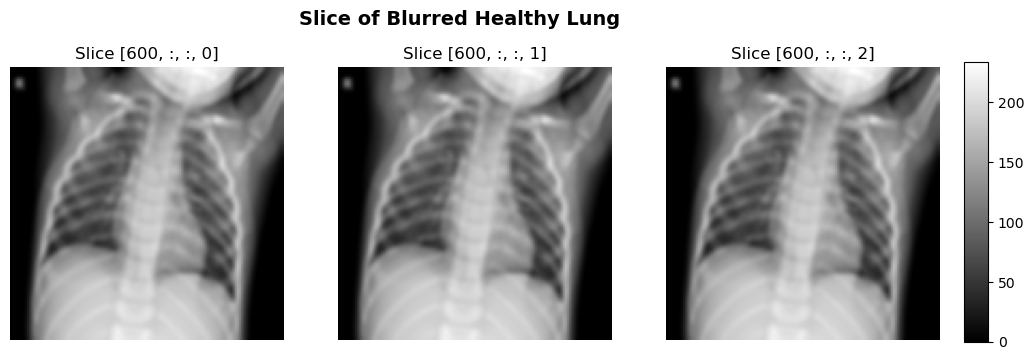

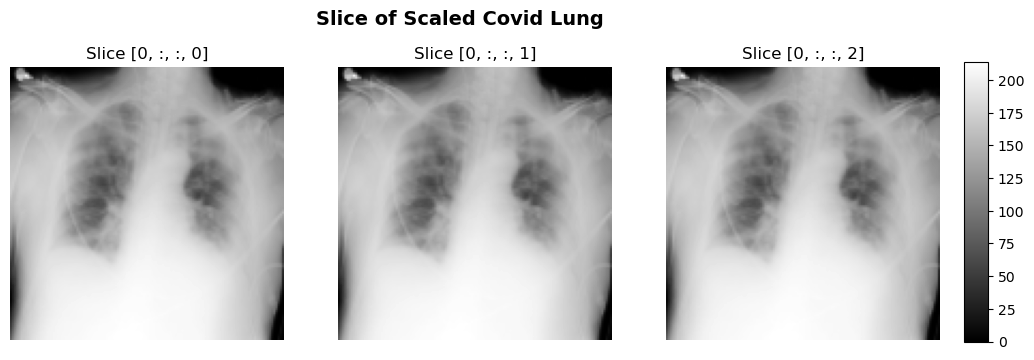

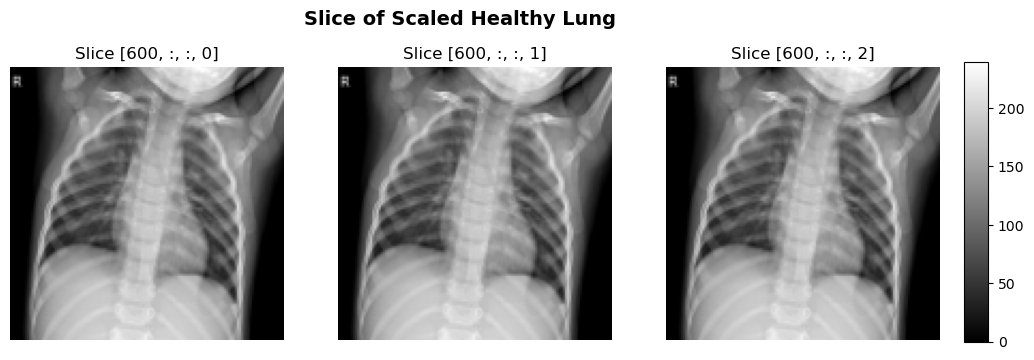

In [231]:
# Show unaltered lungs
print_image(X_train, COVID, "Slice of Covid Lung")
print_image(X_train, HEALTHY, "Slice of Normal Lung")

# Create training sets
y_train_cat = np.concatenate((y_train, np.copy(y_train)), axis=0)
X_train_dup = np.concatenate((X_train, np.copy(X_train)), axis=0)
X_train_blur = blur_data(X_train)
X_train_scale = scale_data(X_train)

# Shuffle training sets
idx = np.arange(X_train_dup.shape[0])
np.random.shuffle(idx)

y_train_cat = y_train_cat[idx]
X_train_dup = X_train_dup[idx]
X_train_blur = X_train_blur[idx]
X_train_scale = X_train_scale[idx]


In [79]:
print(X_train_dup.shape)
print(X_val.shape)

(4000, 128, 128, 3)
(1500, 128, 128, 3)


### 2D Convolutional Neural Network Training

**Model** The 2D convolutional neural network model architecture is shown below. The model is trained to 100 epochs, and the epoch with the highest accuracy is saved and used for further analysis. Training and validation loss plots along with accuracy plots for each of the model training are shown below.

In [232]:
def modelArchitecture2D(X_train, model_type, y_t = y_train_cat): # Model architecture
    model = tf.keras.Sequential([

        tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
        
        tf.keras.layers.Conv2D(8, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint(f"/Users/allenchang/Downloads/CovidDataset/best{model_type}_model.keras", monitor='val_accuracy', save_best_only=True, mode='max')
    history = model.fit(X_train, y_t, epochs = 100, batch_size = 16, validation_data=(X_val, y_val), verbose=1, callbacks=[checkpoint])
    
    model.load_weights(f"/Users/allenchang/Downloads/CovidDataset/best{model_type}_model.keras")
    
    return history, model


In [233]:
def train_model(X_t, model_type, y_t = y_train_cat, X_val = X_val, y_val = y_val): # Trains model and plots the model progress
    
    history, model = modelArchitecture2D(X_t, model_type)
    
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(10, 6))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Validation Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'ro', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    
#     plt.savefig(f'/Users/allenchang/Downloads/CovidDataset/{model_type}.png')
    plt.show()

    validation_loss, validation_accuracy = model.evaluate(X_val, y_val)
    print(f"Validation accuracy: {validation_accuracy:.4f}")
    
    return model, history
    

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 68ms/step - accuracy: 0.8770 - loss: 0.3470 - val_accuracy: 0.6613 - val_loss: 0.8562
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9369 - loss: 0.1641 - val_accuracy: 0.6367 - val_loss: 0.7324
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9355 - loss: 0.1492 - val_accuracy: 0.5920 - val_loss: 0.8113
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9505 - loss: 0.1175 - val_accuracy: 0.7393 - val_loss: 0.6467
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9579 - loss: 0.1079 - val_accuracy: 0.6560 - val_loss: 0.9971
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9647 - loss: 0.0919 - val_accuracy: 0.6713 - val_loss: 0.8633
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9529 - loss: 0.1067 - val_accuracy: 0.6120 - val_loss: 1.0245
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9716 - loss: 0

250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9938 - loss: 0.0184 - val_accuracy: 0.7780 - val_loss: 1.0609
Epoch 51/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.9937 - loss: 0.0196 - val_accuracy: 0.7393 - val_loss: 1.5287
Epoch 52/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9909 - loss: 0.0269 - val_accuracy: 0.7420 - val_loss: 1.6990
Epoch 53/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9960 - loss: 0.0117 - val_accuracy: 0.7893 - val_loss: 1.1185
Epoch 54/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9931 - loss: 0.0196 - val_accuracy: 0.7607 - val_loss: 1.3147
Epoch 55/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9937 - loss: 0.0146 - val_accuracy: 0.6707 - val_loss: 2.1327
Epoch 56/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9928 - loss: 0.0213 - val_accuracy: 0.6833 - val_loss: 1.6812
Epoch 57/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9936 - loss: 0.0139

250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9952 - loss: 0.0210 - val_accuracy: 0.7507 - val_loss: 1.5686
Epoch 100/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9972 - loss: 0.0097 - val_accuracy: 0.7107 - val_loss: 2.0130


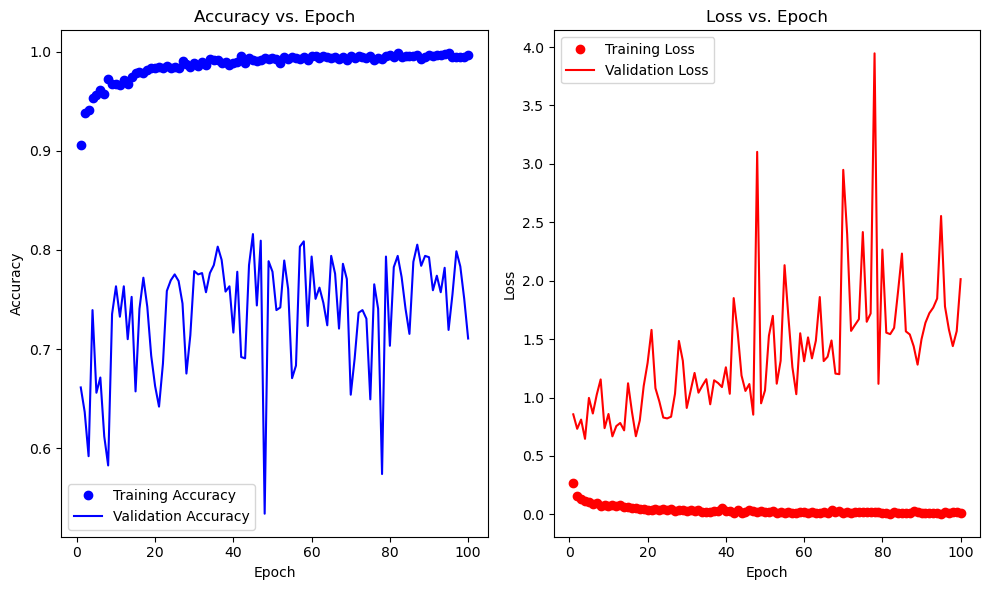

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8009 - loss: 0.8420
Validation accuracy: 0.8160


In [234]:
doubleModel, doubleHistory = train_model(X_train_dup, "Duplicated")

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.8463 - loss: 0.4268 - val_accuracy: 0.6213 - val_loss: 0.6898
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9194 - loss: 0.1951 - val_accuracy: 0.5047 - val_loss: 1.0178
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9267 - loss: 0.1625 - val_accuracy: 0.6093 - val_loss: 0.9544
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9323 - loss: 0.1493 - val_accuracy: 0.6353 - val_loss: 0.8251
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9415 - loss: 0.1308 - val_accuracy: 0.5680 - val_loss: 1.0888
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9483 - loss: 0.1244 - val_accuracy: 0.7313 - val_loss: 0.6989
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9517 - loss: 0.1122 - val_accuracy: 0.7400 - val_loss: 0.6641
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.9538 - loss: 0

250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9924 - loss: 0.0261 - val_accuracy: 0.7620 - val_loss: 1.3623
Epoch 51/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9873 - loss: 0.0381 - val_accuracy: 0.7593 - val_loss: 1.1835
Epoch 52/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9925 - loss: 0.0216 - val_accuracy: 0.7300 - val_loss: 1.6704
Epoch 53/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9844 - loss: 0.0380 - val_accuracy: 0.7460 - val_loss: 1.2737
Epoch 54/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9884 - loss: 0.0244 - val_accuracy: 0.7767 - val_loss: 1.2277
Epoch 55/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9921 - loss: 0.0198 - val_accuracy: 0.7473 - val_loss: 1.5984
Epoch 56/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9900 - loss: 0.0268 - val_accuracy: 0.7253 - val_loss: 1.6109
Epoch 57/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9914 - loss: 0.0226

250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9955 - loss: 0.0131 - val_accuracy: 0.7573 - val_loss: 1.8055
Epoch 100/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9934 - loss: 0.0203 - val_accuracy: 0.7533 - val_loss: 1.6531


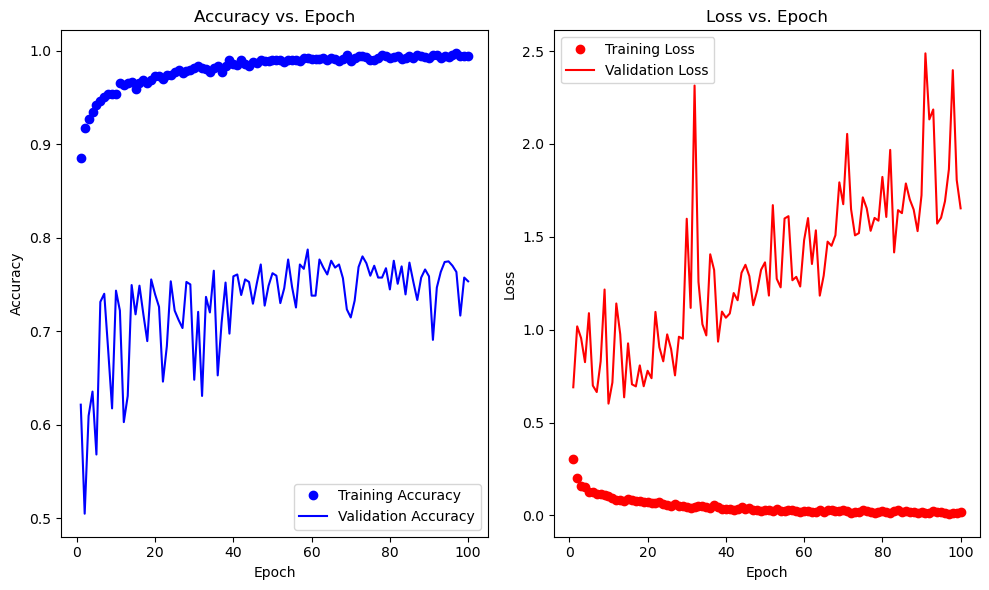

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6904 - loss: 1.3762
Validation accuracy: 0.7873


In [235]:
blurModel, blurHistory = train_model(X_train_blur, "Blurred")

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - accuracy: 0.8722 - loss: 0.3598 - val_accuracy: 0.6727 - val_loss: 0.7832
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9222 - loss: 0.1925 - val_accuracy: 0.6413 - val_loss: 0.7916
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9379 - loss: 0.1467 - val_accuracy: 0.6780 - val_loss: 0.7657
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9487 - loss: 0.1244 - val_accuracy: 0.7073 - val_loss: 0.6688
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9554 - loss: 0.1156 - val_accuracy: 0.7273 - val_loss: 0.6126
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9604 - loss: 0.1052 - val_accuracy: 0.7433 - val_loss: 0.7052
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9618 - loss: 0.0949 - val_accuracy: 0.6740 - val_loss: 0.9996
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.9532 - loss: 0

250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 153ms/step - accuracy: 0.9900 - loss: 0.0325 - val_accuracy: 0.7753 - val_loss: 1.3173
Epoch 51/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9899 - loss: 0.0283 - val_accuracy: 0.7813 - val_loss: 1.2114
Epoch 52/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9906 - loss: 0.0274 - val_accuracy: 0.7760 - val_loss: 1.1578
Epoch 53/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.9916 - loss: 0.0254 - val_accuracy: 0.7927 - val_loss: 1.3665
Epoch 54/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.9933 - loss: 0.0162 - val_accuracy: 0.7860 - val_loss: 1.6108
Epoch 55/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.9948 - loss: 0.0135 - val_accuracy: 0.7927 - val_loss: 1.1210
Epoch 56/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.9956 - loss: 0.0135 - val_accuracy: 0.7673 - val_loss: 1.5703
Epoch 57/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.9869 - loss: 0.038

250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9949 - loss: 0.0119 - val_accuracy: 0.7960 - val_loss: 1.6293
Epoch 100/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9975 - loss: 0.0096 - val_accuracy: 0.7813 - val_loss: 1.6379


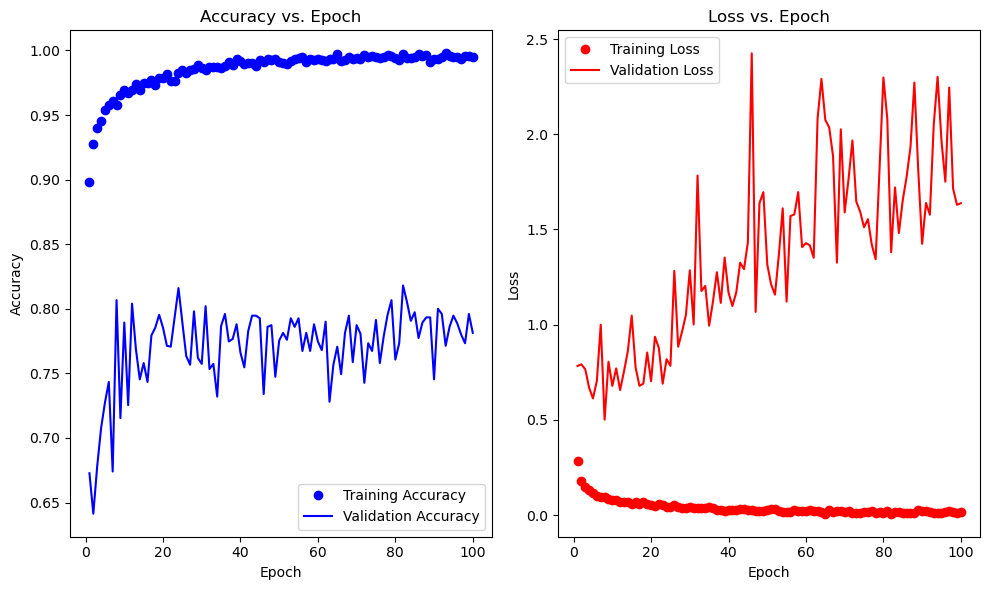

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8475 - loss: 0.8966
Validation accuracy: 0.8180


In [236]:
scaleModel, scaleHistory = train_model(X_train_scale, "Scaled")

### Comparative Model Analysis

**Comparing Augmentation Methods** The control model has the highest F1-score and accuracy. It has the second highest AUROC, precision, and recall. The model trained on blurred data has the lowest AUROC, F1-score, and precision. It has the highest recall and second highest accuracy. The model trained on scaled data has the highest AUROC and precision. It has the second highest F1-score and lowest recall and accuracy. Interestingly, the model trained on scaled data also has a much lower recall and higher false positive rate.

In [237]:
Xtest_C = load_images(testC)
Xtest_N = load_images(testN)
Xtest_C_avg = np.mean(Xtest_C, axis = 0)
Xtest_N_avg = np.mean(Xtest_N, axis = 0)

(500, 128, 128, 3)
(500, 128, 128, 3)


In [239]:
doubleModel = tf.keras.models.load_model("/Users/allenchang/Downloads/CovidDataset/bestDuplicated_model.keras")
blurModel = tf.keras.models.load_model("/Users/allenchang/Downloads/CovidDataset/bestBlurred_model.keras")
scaleModel = tf.keras.models.load_model("/Users/allenchang/Downloads/CovidDataset/bestScaled_model.keras")

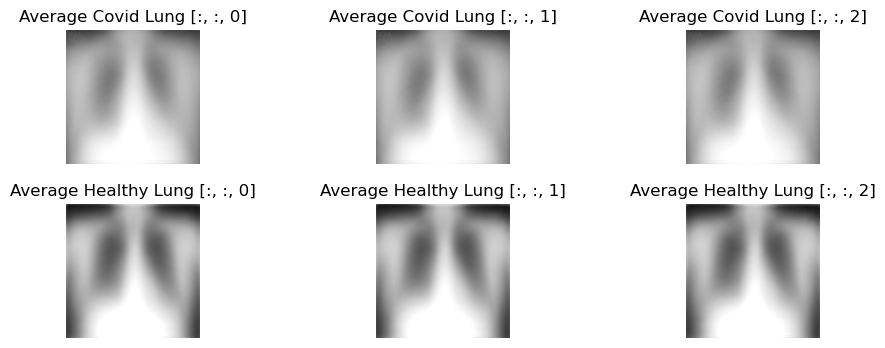

In [264]:
def plot_avg_testimage(Xtest_C_avg = Xtest_C_avg, Xtest_N_avg = Xtest_N_avg):
    fig, axs = plt.subplots(2, 3, figsize=(12, 4))
    cmp = 'gist_gray'
    vmax = 200
    vmin = 0

    axs[0, 0].imshow(Xtest_C_avg[:, :, 0], cmap=cmp, vmax=vmax, vmin=vmin)
    axs[0, 0].set_title(f"Average Covid Lung [:, :, 0]")
    axs[0, 0].axis("off")

    axs[0, 1].imshow(Xtest_C_avg[:, :, 1], cmap=cmp, vmax=vmax, vmin=vmin)
    axs[0, 1].set_title(f"Average Covid Lung [:, :, 1]")
    axs[0, 1].axis("off")

    axs[0, 2].imshow(Xtest_C_avg[:, :, 2], cmap=cmp, vmax=vmax, vmin=vmin)
    axs[0, 2].set_title(f"Average Covid Lung [:, :, 2]")
    axs[0, 2].axis("off")

    # Second row: Xtrain_N_avg
    axs[1, 0].imshow(Xtest_N_avg[:, :, 0], cmap=cmp, vmax=vmax, vmin=vmin)
    axs[1, 0].set_title(f"Average Healthy Lung [:, :, 0]")
    axs[1, 0].axis("off")

    axs[1, 1].imshow(Xtest_N_avg[:, :, 1], cmap=cmp, vmax=vmax, vmin=vmin)
    axs[1, 1].set_title(f"Average Healthy Lung [:, :, 1]")
    axs[1, 1].axis("off")

    axs[1, 2].imshow(Xtest_N_avg[:, :, 2], cmap=cmp, vmax=vmax, vmin=vmin)
    axs[1, 2].set_title(f"Average Healthy Lung [:, :, 2]")
    axs[1, 2].axis("off")
#     

    plt.subplots_adjust(wspace=0, hspace=0.3)
    
#     plt.savefig(f'/Users/allenchang/Downloads/CovidDataset/average.png')
    
    plt.show()

plot_avg_testimage()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


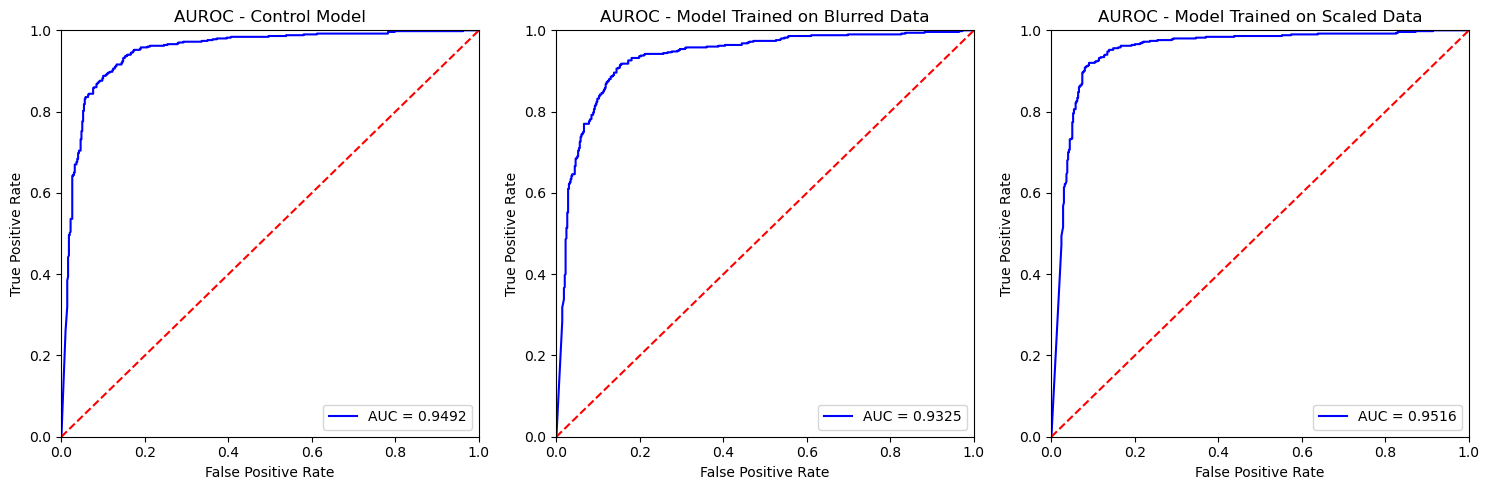

In [243]:
def plot_auroc(X_test = X_test, y_test = y_test, doubleModel = doubleModel, blurModel = blurModel, scaleModel = scaleModel):
    # Predictions for each model
    doublepred = doubleModel.predict(X_test)
    blurpred = blurModel.predict(X_test)
    scalepred = scaleModel.predict(X_test)
    
    # Calculate AUROC for each model
    fpr_double, tpr_double, _ = roc_curve(y_test, doublepred)
    roc_auc_double = auc(fpr_double, tpr_double)
    
    fpr_blur, tpr_blur, _ = roc_curve(y_test, blurpred)
    roc_auc_blur = auc(fpr_blur, tpr_blur)
    
    fpr_scale, tpr_scale, _ = roc_curve(y_test, scalepred)
    roc_auc_scale = auc(fpr_scale, tpr_scale)
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot AUROC for doubleModel
    axs[0].plot(fpr_double, tpr_double, 'b', label=f'AUC = {roc_auc_double:.4f}')
    axs[0].set_title('AUROC - Control Model')
    axs[0].plot([0, 1], [0, 1], 'r--')
    axs[0].set_xlim([0, 1])
    axs[0].set_ylim([0, 1])
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_xlabel('False Positive Rate')
    
    # Plot AUROC for blurModel
    axs[1].plot(fpr_blur, tpr_blur, 'b', label=f'AUC = {roc_auc_blur:.4f}')
    axs[1].set_title('AUROC - Model Trained on Blurred Data')
    axs[1].plot([0, 1], [0, 1], 'r--')
    axs[1].set_xlim([0, 1])
    axs[1].set_ylim([0, 1])
    axs[1].set_ylabel('True Positive Rate')
    axs[1].set_xlabel('False Positive Rate')
    
    # Plot AUROC for scaleModel
    axs[2].plot(fpr_scale, tpr_scale, 'b', label=f'AUC = {roc_auc_scale:.4f}')
    axs[2].set_title('AUROC - Model Trained on Scaled Data')
    axs[2].plot([0, 1], [0, 1], 'r--')
    axs[2].set_xlim([0, 1])
    axs[2].set_ylim([0, 1])
    axs[2].set_ylabel('True Positive Rate')
    axs[2].set_xlabel('False Positive Rate')
    
    for ax in axs:
        ax.legend(loc='lower right')
    
    plt.tight_layout()
    
    
#     plt.savefig(f'/Users/allenchang/Downloads/CovidDataset/AUROC.png')
    plt.show()
    
    return doublepred, blurpred, scalepred

doublepred, blurpred, scalepred = plot_auroc()


In [241]:
def prediction_metrics(doublepred = doublepred, blurpred = blurpred, scalepred = scalepred, y_test = y_test):
    # Round predictions to 0 or 1 for discrete analysis
    doublepred = np.round(doublepred).astype(int)
    blurpred = np.round(blurpred).astype(int)
    scalepred = np.round(scalepred).astype(int)

    print(f"The f1-score for the Control Model is {f1_score(doublepred, y_test)}")
    print(f"The f1-score for the Model trained on Blurred data is {f1_score(blurpred, y_test)}")
    print(f"The f1-score for the Model trained on Scaled data is {f1_score(scalepred, y_test)}")
    print()
    print(f"The precision for the Control Model is {precision_score(doublepred, y_test)}")
    print(f"The precision for the Model trained on Blurred data is {precision_score(blurpred, y_test)}")
    print(f"The precision for the Model trained on Scaled data is {precision_score(scalepred, y_test)}")
    print()
    print(f"The recall for the Control Model is {recall_score(doublepred, y_test)}")
    print(f"The recall for the Model trained on Blurred data is {recall_score(blurpred, y_test)}")
    print(f"The recall for the Model trained on Scaled data is {recall_score(scalepred, y_test)}")
    print()
    print(f"The accuracy the Control Model is {accuracy_score(doublepred, y_test)}")
    print(f"The accuracy for the Model trained on Blurred data is {accuracy_score(blurpred, y_test)}")
    print(f"The accuracy for the Model trained on Scaled data is {accuracy_score(scalepred, y_test)}")

prediction_metrics()

The f1-score for the Control Model is 0.8938967136150234
The f1-score for the Model trained on Blurred data is 0.8792934249263985
The f1-score for the Model trained on Scaled data is 0.8814479638009051

The precision for the Control Model is 0.952
The precision for the Model trained on Blurred data is 0.896
The precision for the Model trained on Scaled data is 0.974

The recall for the Control Model is 0.8424778761061947
The recall for the Model trained on Blurred data is 0.8631984585741811
The recall for the Model trained on Scaled data is 0.8049586776859504

The accuracy the Control Model is 0.887
The accuracy for the Model trained on Blurred data is 0.877
The accuracy for the Model trained on Scaled data is 0.869


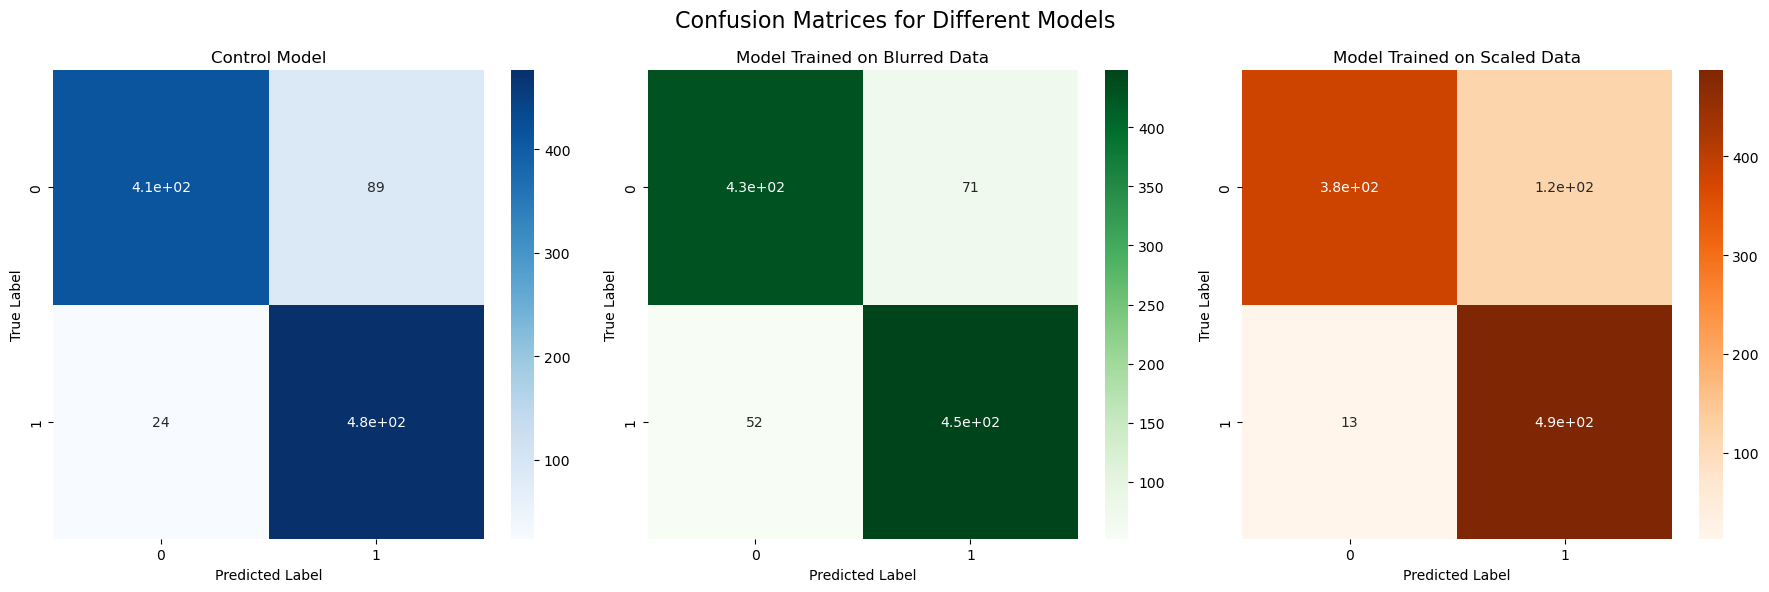

In [246]:
doublepred = np.round(doublepred).astype(int)
blurpred = np.round(blurpred).astype(int)
scalepred = np.round(scalepred).astype(int)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Confusion Matrices for Different Models", fontsize=16)

# Control Model Confusion Matrix
double_matrix = confusion_matrix(y_test, doublepred)
sns.heatmap(double_matrix, annot=True, cmap='Blues', ax=axes[0])
axes[0].set_title("Control Model")
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')


# Blurred Model Confusion Matrix
blurred_matrix = confusion_matrix(y_test, blurpred)
sns.heatmap(blurred_matrix, annot=True, cmap='Greens', ax=axes[1])
axes[1].set_title("Model Trained on Blurred Data")
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

# Scaled Model Confusion Matrix
scaled_matrix = confusion_matrix(y_test, scalepred)
sns.heatmap(scaled_matrix, annot=True, cmap='Oranges', ax=axes[2])
axes[2].set_title("Model Trained on Scaled Data")
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')



plt.tight_layout()

plt.savefig(f'/Users/allenchang/Downloads/CovidDataset/confusion.png')
plt.show()

## Concluding Remarks

To accomodate time and memory requirements, datasets were trimmed down and scaled from the original dataset according to the parameters above. Models were also only ran to 100 epochs. However, this seems sufficient, since overfitting can be observed as validation loss increases. Nevertheless, more tests can be performed in the future to determine whether the following augmentation methods truly present a statistically significant difference in performance. Furthermore, as mentioned before, more experimentation with different architectures or hyperparameters may result in better model performance. Model weights are available upon request. 